In [1]:
import numpy as np
from pyrosetta import *
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import glob
import sys
import math
sys.path.append('scripts/')
import utils
import shutil
import jupyter_utils
import subprocess
import string
import bwicky_utils
import scoring_utils

PyRosetta-4 2020 [Rosetta PyRosetta4.conda.linux.cxx11thread.serialization.CentOS.python37.Release 2020.18+release.24657a3ea486fc9adceafe7fe31e4d51238883cc 2020-04-28T22:07:25] retrieved from: http://www.pyrosetta.org
(C) Copyright Rosetta Commons Member Institutions. Created in JHU by Sergey Lyskov and PyRosetta Team.
PyRosetta-4 2020 [Rosetta PyRosetta4.conda.linux.cxx11thread.serialization.CentOS.python37.Release 2020.18+release.24657a3ea486fc9adceafe7fe31e4d51238883cc 2020-04-28T22:07:25] retrieved from: http://www.pyrosetta.org
(C) Copyright Rosetta Commons Member Institutions. Created in JHU by Sergey Lyskov and PyRosetta Team.
PyRosetta-4 2020 [Rosetta PyRosetta4.conda.linux.cxx11thread.serialization.CentOS.python37.Release 2020.18+release.24657a3ea486fc9adceafe7fe31e4d51238883cc 2020-04-28T22:07:25] retrieved from: http://www.pyrosetta.org
(C) Copyright Rosetta Commons Member Institutions. Created in JHU by Sergey Lyskov and PyRosetta Team.


# Launch trRosetta design using various modes

In [2]:
pdbs = glob.glob('in/foldit_pdbs_200/*.pdb')

In [2]:
# Start trRosetta designs v2
cmdfile = 'cmds_trdesign_traditional'
outdir = 'out/trR_design_paper1_style/trR_designs_v2'
os.makedirs(outdir, exist_ok=True)
with open(cmdfile,'w') as f_out:
    for pdb in pdbs:
        identifier = pdb.split('/')[-1].replace('.pdb','')
        os.makedirs('out/trR_designs/'+identifier, exist_ok=True)
         
        cmd = 'python /home/krypton/projects/TrR_for_design_v2/design.py -p {pdb} -o out/trR_designs/{id}/out.txt -n 100 --add_aa --rm_aa C --save_npz --save_img --save_pdb'
        f_out.write(cmd.format(pdb=pdb, id=identifier)+'\n')

#submitfile = cmdfile+'.sh'
#jupyter_utils.make_submit_file(cmds=cmdfile, submitfile=submitfile,group_size=1, cpus=4, mem='8gb', logsfolder='logs_tr', needs_gpu=True)
#p = subprocess.Popen(['sbatch', submitfile])

In [4]:
# Run trRosetta newest version
exe5 = '/home/krypton/projects/TrR_for_design_v5_test/design.py'
cmdfile = 'cmds_run_trRosetta5_SEQ'
with open(cmdfile, 'w') as f_out:
    for pdb in pdbs:
        seqid=pdb.split('/')[-1][:-4]
                
        # v5 traditional aa loss
        cmd = f'python {exe5} -p {pdb} -o out/pssm_v5_aakl_1/{seqid}_ -n 100 --aa_weight 1.0 --rm_aa C --cce_cutoff 10'
        f_out.write(cmd+'\n')
        
        # v5 traditional aa loss, no cce_cutoff
        cmd = f'python {exe5} -p {pdb} -o out/pssm_v5_aakl_1_no_cce/{seqid}_ -n 100 --aa_weight 1.0 --rm_aa C'
        f_out.write(cmd+'\n')

submitfile = cmdfile+'.sh'
jupyter_utils.make_submit_file(cmds=cmdfile, submitfile=submitfile,group_size=1, cpus=4, mem='8G', logsfolder='logs', needs_gpu=True)
p = subprocess.Popen(['sbatch', submitfile])

In [3]:
# Run trRosetta / DJ hyperparameterized to make PSSMs directly
exeDJ = '/home/davidcj/projects/nelder_mead/scripts/design_bb_.py'
cmdfile = 'cmds_run_trRosetta5_DJ'
with open(cmdfile, 'w') as f_out:
    for pdb in pdbs:
        seqid=pdb.split('/')[-1][:-4]
                
        # SEQ
        outdir = f'out/pssm_DJ_SEQ/{seqid}'
        cmd = f'/software/conda/envs/tensorflow/bin/python {exeDJ} --pdb {pdb} --n_models 5 -n 1 --out {seqid}\
        --aa_params /home/davidcj/projects/nelder_mead/scripts/nm_concolusions/seq/seq_opt_082620/nm_filtered/params_89 \
        --outdir {outdir} --add_aa_comp --aa_weight 2.490 --natural_H --H_weight 2.3214'
        f_out.write(cmd+'\n')
        os.makedirs(outdir, exist_ok=True)
        
        # MSA
        outdir = f'out/pssm_DJ_MSA/{seqid}'
        cmd = f'/software/conda/envs/tensorflow/bin/python {exeDJ} --pdb {pdb} --n_models 5 -n 1 --out {seqid} --msa_design\
        --aa_params /home/norn/DL/200701_ref_weight_optimization/nelder_mead/scripts/nm_filtered/params_130\
        --outdir {outdir} --add_aa_comp --aa_weight 1.0987 --natural_H --H_weight 1.8115 --feat_drop=0.8'
        f_out.write(cmd+'\n')
        os.makedirs(outdir, exist_ok=True)

        # PSSM
        outdir = f'out/pssm_DJ_PSSM/{seqid}'
        cmd = f'/software/conda/envs/tensorflow/bin/python {exeDJ} --pdb {pdb} --n_models 5 -n 1 --out {seqid} --pssm_design\
        --aa_params /home/davidcj/projects/nelder_mead/scripts/nm_concolusions/pssm/pssm_opt_081420/nm_filtered/params_100\
        --outdir {outdir} --add_aa_comp --aa_weight 1.908 --natural_H --H_weight 1.692'
        f_out.write(cmd+'\n')
        os.makedirs(outdir, exist_ok=True)

submitfile = cmdfile+'.sh'
jupyter_utils.make_submit_file(cmds=cmdfile, submitfile=submitfile, group_size=1, cpus=4, mem='8G', logsfolder='logs', needs_gpu=True)
p = subprocess.Popen(['sbatch', submitfile])

# Make PSSMs

In [3]:
# Generate pssms based on trRosetta runs
def trRosettaOut2pssm(o):
    table = str.maketrans(dict.fromkeys(string.ascii_lowercase))
    aas = 'ARNDCQEGHILKMFPSTWYV'
    #aas = 'AFILVMWYDEKRHNQSTGPC'
    alphabet = np.array(list(aas), dtype='|S1').view(np.uint8)

    # Get the probabilies
    identifier = o.split('/')[-2]
    df = pd.read_csv(o, delim_whitespace=True)
    msa = np.array([list(s) for s in df['sequence']], dtype='|S1').view(np.uint8)
    for i in range(alphabet.shape[0]):
        msa[msa == alphabet[i]] = i
    if len(msa.shape)>1:
        pssm = np.eye(20)[msa].mean(axis=0) + 1e-12

    return pssm

def DJ_PSSMs2PSSM(pssm_f, bg_freqs):
    pssm = np.loadtxt(pssm_f)
    
    # Get the background frequencies
    tr_bg_freqs = np.zeros(20)
    bg_freqs = np.sum(pssm, axis=0) + 1e-6
    bg_freqs = bg_freqs/np.sum(bg_freqs)
    
    return pssm, bg_freqs

def save_pssm(pssm, outfile):
    f_out = open(outfile,'w')
    f_out.write('\n')
    f_out.write('Last position-specific scoring matrix computed, weighted observed percentages rounded down, information per position, and relative weight of gapless real matches to pseudocounts\n')
    f_out.write('            A   R   N   D   C   Q   E   G   H   I   L   K   M   F   P   S   T   W   Y   V   A   R   N   D   C   Q   E   G   H   I   L   K   M   F   P   S   T   W   Y   V\n')

    for i in range(pssm.shape[0]):
        aa = 'A'
        pos = str(i+1)
        odds = pssm[i,:]
        odds_str = ' '.join([str(x) for x in odds])
        occ_str = ' '.join([str(1.0) for x in odds])
        f_out.write(pos+' '+aa+' '+odds_str+' '+occ_str+' 0.00 0.00'+'\n')
    f_out.write('\n\n\n\n')

def viz_pssm(pssm, pid):
    logodds = pssm
    sns.set(rc={'figure.figsize':(20,5.0)})
    aas = 'ARNDCQEGHILKMFPSTWYV'
    x = logodds.transpose()
    g = sns.heatmap(logodds.transpose(), yticklabels=list(aas), cmap='RdBu', vmin=-1, vmax=1)
    plt.title(pid)
    plt.show()

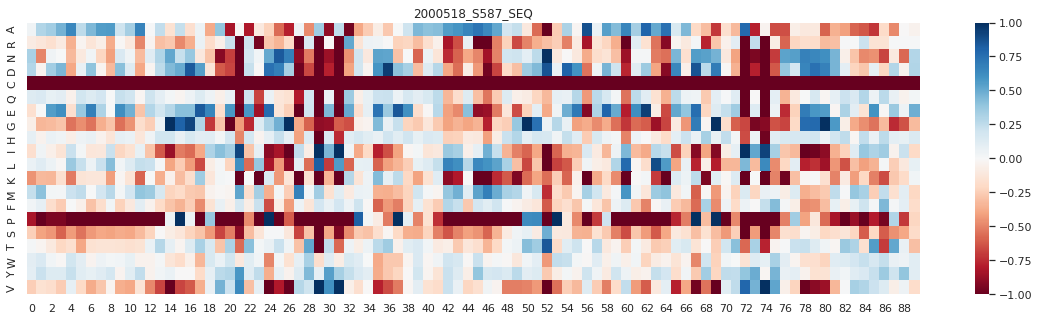

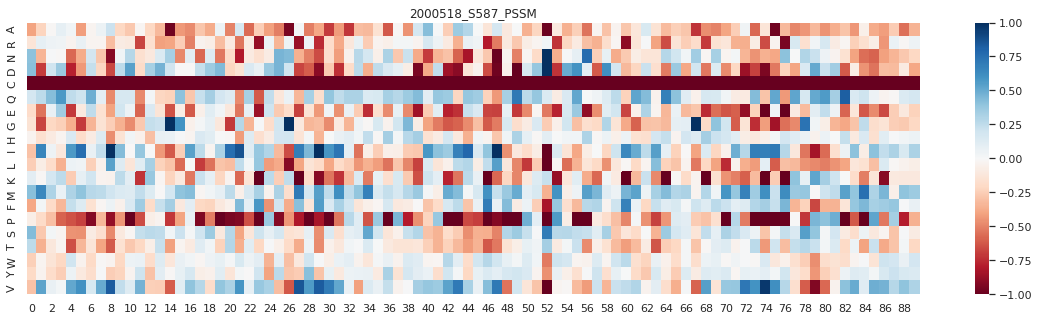

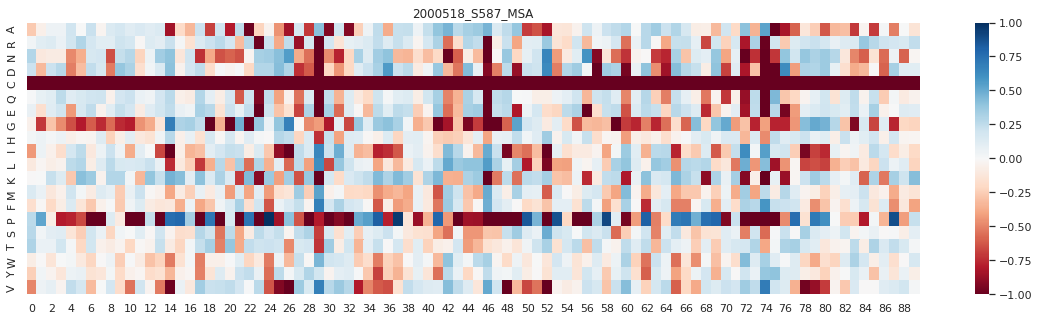

In [4]:
# Make PSSMs from DJ
DJ_PSSM_types = ['SEQ', 'PSSM', 'MSA']
for pssm_type in DJ_PSSM_types:
    pssm_fs = glob.glob(f'out/pssm_DJ_{pssm_type}/*/*pssm.txt')
    pids = [pssm_f.split('/')[-1].split('.')[0] for pssm_f in pssm_fs]
    pssms = np.array([np.loadtxt(pssm_f) for pssm_f in pssm_fs])
    
    # compute bg freqs
    pssms_concat = np.concatenate(pssms)
    bg_freqs = pssms_concat.mean(axis=0)
    bg_freqs = bg_freqs/np.sum(bg_freqs)
    
    # write the pssm in the format rosetta expects
    for i,(pid,pssm) in enumerate(zip(pids,pssms)):
        pssm = np.log(pssm/bg_freqs)
        pssm[:,4] = -10
        if pid=='2000518_S587':
            viz_pssm(pssm, f'{pid}_{pssm_type}')
        save_pssm(pssm, f'out/final_pssms/{pid}_{pssm_type}.pssm')
        

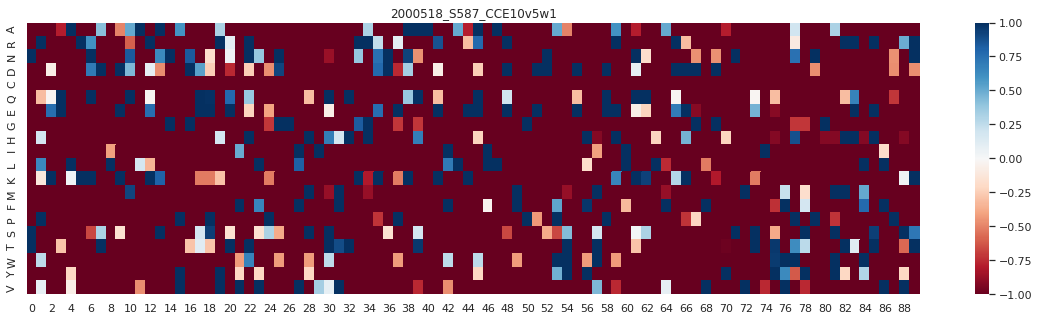

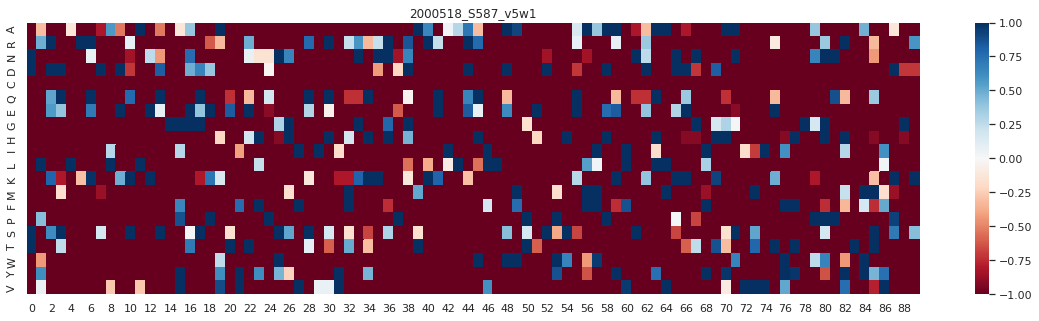

In [5]:
# Make PSSMs using the traditional approach (but in constrast to the paper, include cce_cutoff=10)
pssm_type_shorthand = ['CCE10v5w1','v5w1']
PSSM_types = ['pssm_v5_aakl_1_no_cce', 'pssm_v5_aakl_1']
for pssm_type, pssm_type_path in zip(pssm_type_shorthand, PSSM_types):
    outfiles = glob.glob(f'out/{pssm_type_path}/*txt')
    pids = [f.split('/')[-1][:-5] for f in outfiles]
    pssms = np.array([trRosettaOut2pssm(of) for of in outfiles])
    pssms_concat = np.concatenate(pssms)
    bg_freqs = pssms_concat.mean(axis=0)
    bg_freqs = bg_freqs/np.sum(bg_freqs)
    
    for i,(pid,pssm) in enumerate(zip(pids,pssms)):
        pssm = np.log(pssm/bg_freqs)
        pssm[:,4] = -10
        if '2000518_S587' in pid:
            viz_pssm(pssm, f'{pid}_{pssm_type}')
        save_pssm(pssm, f'out/final_pssms/{pid}_{pssm_type}.pssm')
    

In [8]:
# How to use them? Run all with one cutoff -1, and one weight 0.3
cmdfile = 'cmds_rosetta_design'
outdir = 'out/R_designs_w_pssm_final/'
os.makedirs(outdir, exist_ok=True)
rs = '/net/software/rosetta/latest/bin/rosetta_scripts.hdf5.linuxgccrelease'
protocol = 'protocols/redesign_all_fastdesign_pssm.xml'

with open(cmdfile,'w') as f_out:
    for pdb in glob.glob('in/foldit_pdbs_200/*.pdb'):
        identifier = pdb.split('/')[-1].replace('.pdb','')
        pssms = glob.glob(f'out/final_pssms_logodds/{identifier}*')
        if len(pssms)==6:
            for pssm_path in pssms:
                pssmid = pssm_path.split('_')[-1][:-5]
                cmd = f'{rs} -s {pdb} -out:prefix={outdir}{pssmid}_ -parser:script_vars pssm_weight=0.3 pssm_cutoff=-1 pssm={pssm_path} -parser:protocol {protocol} -score:weights protocols/beta16_nostab.wts -corrections:beta_nov16 -holes:dalphaball=/software/rosetta/DAlphaBall.gcc'
                f_out.write(cmd+'\n')
        else:
            print("missing pssms for ", {pdb})

submitfile = cmdfile+'.sh'
jupyter_utils.make_submit_file(cmds=cmdfile, submitfile=submitfile,group_size=1, cpus=1, mem='4G', logsfolder='logs')
#p = subprocess.Popen(['sbatch', submitfile])

missing pssms for  {'in/foldit_pdbs_200/996511_0003.pdb'}
missing pssms for  {'in/foldit_pdbs_200/996511_0000.pdb'}
missing pssms for  {'in/foldit_pdbs_200/996560_0000.pdb'}
